In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
from geopy import distance
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip
from branca.colormap import LinearColormap
from collections import Counter
import geopy.distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [24]:
Capital_bike_share = pd.read_csv('dc_bikes_sample_3000.csv', sep=',')

In [25]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time'],
      dtype='object')

In [26]:
# Convert started_at and ended_at to datetime for memory efficiency
Capital_bike_share['started_at'] = pd.to_datetime(Capital_bike_share['started_at'])
Capital_bike_share['ended_at'] = pd.to_datetime(Capital_bike_share['ended_at'])

In [27]:
# Calculate ride duration in hours
Capital_bike_share['duration_hours'] = (Capital_bike_share['ended_at'] - Capital_bike_share['started_at']).dt.total_seconds() / 3600

# Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth using the Haversine formula.
    Inputs:
    - lat1, lon1: Latitude and longitude of point 1 in degrees.
    - lat2, lon2: Latitude and longitude of point 2 in degrees.
    Output:
    - Distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [28]:
# Calculate distance for each ride
Capital_bike_share['distance_km'] = Capital_bike_share.apply(
    lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']),
    axis=1
)

# Calculate speed in km/h
Capital_bike_share['speed_kmh'] = Capital_bike_share['distance_km'] / Capital_bike_share['duration_hours']

In [29]:
# --- Step 1: Convert 'started_at' and 'ended_at' to datetime format ---
Capital_bike_share['started_at'] = pd.to_datetime(Capital_bike_share['started_at'])
Capital_bike_share['ended_at'] = pd.to_datetime(Capital_bike_share['ended_at'])

# --- Step 2: Calculate ride duration in minutes ---
Capital_bike_share['ride_duration'] = (Capital_bike_share['ended_at'] - Capital_bike_share['started_at']).dt.total_seconds() / 60  # Convert to minutes

# Display the updated DataFrame
print(Capital_bike_share)

        ride_id  rideable_type          started_at            ended_at  \
0        3363.0   classic_bike 2021-01-02 13:56:30 2021-01-02 14:02:06   
1       97357.0    docked_bike 2021-01-30 15:34:48 2021-01-30 17:05:41   
2       46177.0   classic_bike 2021-01-15 07:11:24 2021-01-15 07:13:20   
3       95158.0   classic_bike 2021-01-30 06:49:29 2021-01-30 06:54:30   
4       41194.0   classic_bike 2021-01-13 17:42:09 2021-01-13 17:46:28   
...         ...            ...                 ...                 ...   
107995      NaN   classic_bike 2023-12-17 13:55:51 2023-12-17 14:01:24   
107996      NaN   classic_bike 2023-12-09 09:44:07 2023-12-09 09:55:03   
107997      NaN  electric_bike 2023-12-04 23:03:13 2023-12-04 23:21:05   
107998      NaN   classic_bike 2023-12-11 09:23:48 2023-12-11 09:27:21   
107999      NaN  electric_bike 2023-12-13 17:28:45 2023-12-13 17:41:42   

                                  start_station_name  start_station_id  \
0                                    

In [30]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time',
       'distance_km', 'speed_kmh', 'ride_duration'],
      dtype='object')

In [31]:
Capital_bike_share['Season'].unique

<bound method Series.unique of 0         winter
1         winter
2         winter
3         winter
4         winter
           ...  
107995    winter
107996    winter
107997    winter
107998    winter
107999    winter
Name: Season, Length: 108000, dtype: object>

Mean Squared Error: 76.67409108965221
R-squared: -0.006832714827530895


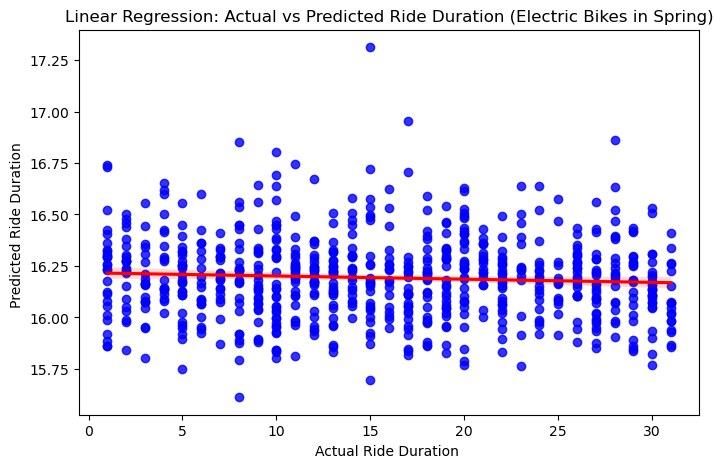

In [36]:
# --- Step 1: Filter only electric bike rides in Spring ---
Capital_bike_share = Capital_bike_share[(Capital_bike_share['rideable_type'] == 'electric_bike') & (Capital_bike_share['Season'] == 'Spring')]

# --- Step 2: Encode categorical station data ---
label_encoder = LabelEncoder()
Capital_bike_share['start_station_name_encoded'] = label_encoder.fit_transform(Capital_bike_share['start_station_name'])
Capital_bike_share['end_station_name_encoded'] = label_encoder.fit_transform(Capital_bike_share['end_station_name'])

# --- Step 3: Select features and target variable ---
X = Capital_bike_share[['distance_km', 'dow', 'start_station_name_encoded', 'end_station_name_encoded']]  # Features
y = Capital_bike_share['day']  # Target variable (predicting ride duration)

# --- Step 4: Split into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 5: Train the Linear Regression model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Step 6: Make predictions ---
y_pred = model.predict(X_test)

# --- Step 7: Evaluate model performance ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# --- Step 8: Visualize results ---
plt.figure(figsize=(8, 5))
sns.regplot(x=y_test, y=y_pred, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Actual Ride Duration ")
plt.ylabel("Predicted Ride Duration ")
plt.title("Linear Regression: Actual vs Predicted Ride Duration (Electric Bikes in Spring)")
plt.show()


In [ ]:

# Generate some sample data
np.random.seed(42)
num_points = 20
x=10*np.random.normal(0,1,num_points)
y=10*(x**2)+np.random.normal(-400,400,num_points)

# Function to fit and plot polynomial regression
def plot_polynomial_regression(degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_pred = polynomial(x)

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="Data")
    plt.plot(np.sort(x), y_pred[np.argsort(x)], color='red', label="Polynomial Regression (Degree {})".format(degree))
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Polynomial Regression")

# Create an interactive widget for degree selection
degree_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Degree')

# Create a function to update the plot when the slider is moved
def update_plot(change):
    clear_output()
    display(degree_slider, output)

degree_slider.observe(update_plot, 'value')

# Create an interactive output
output = widgets.interactive_output(plot_polynomial_regression, {'degree': degree_slider})

# Display the widgets and the output
display(degree_slider, output)

IntSlider(value=5, description='Degree', max=10, min=1)

Output()